# Summary

This notebook is organized into the following sections:

- [Solving Dependencies](#Solving-Dependencies)
- [Importing Data](#Importing-Data)
- [Defining Training and Testing Functions](#defining-training-and-testing-functions)
- [BERT Model](#bert-model)
- [XLNet Model](#xlnet-model)


# Solving Dependencies

In [ ]:
from pathlib import Path

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from transformers import BertTokenizer, BertForSequenceClassification, \
    XLNetTokenizer, XLNetForSequenceClassification

# Set seed
SEED = 461249612

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Importing Data

In [24]:
# Open the Excel file
df = pd.read_excel('datasets/FakeRecogna/FakeRecogna.xlsx')

# Print information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11903 entries, 0 to 11902
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Titulo     11872 non-null  object 
 1   Subtitulo  5580 non-null   object 
 2   Noticia    11902 non-null  object 
 3   Categoria  11902 non-null  object 
 4   Data       11551 non-null  object 
 5   Autor      11886 non-null  object 
 6   URL        11902 non-null  object 
 7   Classe     11902 non-null  float64
dtypes: float64(1), object(7)
memory usage: 744.1+ KB
None


In [25]:
df = df.dropna(subset=['Noticia', 'Classe'])  # Drop rows with missing values in 'Noticia' or 'Classe'
df.rename(columns={'Noticia': 'text', 'Classe': 'label'}, inplace=True)

df = df[['text', 'label']]

In [26]:
df

text  label
0      apagão vaticano papar presar acusação tráfico ...    0.0
1      o governar equador anunciar preparar cova cole...    1.0
2      o companhia air france operar voar direto pequ...    1.0
3      o marfrig global foods retomar vender carnar b...    1.0
4      o assunto voltar o compartilhar rede social ju...    0.0
...                                                  ...    ...
11898  argentino marcar tendência mundial vacinar o c...    0.0
11899  o ministrar saudar marcelo queiroga e represen...    1.0
11900  o vídeo recentemente publicar página “ 18:18 ”...    0.0
11901  parir afp o frança impor tocar recolher o 20h ...    1.0
11902  equipamento simulação fraudar vídeo antigo vol...    0.0

[11902 rows x 2 columns]

# Defining Training and Testing Functions

In [35]:
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs, device):
    """
    Train and validate a model with additional metrics: accuracy, precision, recall, and F1 score.

    Args:
        model: The PyTorch model to be trained.
        train_dataloader: DataLoader for the training set.
        val_dataloader: DataLoader for the validation set.
        optimizer: Optimizer for training the model.
        num_epochs: Number of epochs for training.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        metrics_dict: Dictionary with training and validation metrics for each epoch.
    """
    model = model.to(device)
    
    # Initialize dictionary to store metrics
    metrics_dict = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1} [Training]')
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Update progress bar
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{total_loss/(progress_bar.n+1):.4f}'})
            
            # Collect predictions and labels for metrics calculation
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # Calculate average training loss and metrics
        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
        
        # Store training metrics
        metrics_dict['train_loss'].append(avg_train_loss)
        metrics_dict['train_accuracy'].append(train_accuracy)
        metrics_dict['train_precision'].append(precision)
        metrics_dict['train_recall'].append(recall)
        metrics_dict['train_f1'].append(f1)
        
        print(f'\nEpoch {epoch + 1} - Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        
        # Validation phase
        model.eval()
        val_total_loss = 0
        all_val_preds = []
        all_val_labels = []
        
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc=f'Epoch {epoch + 1} [Validation]')
            
            for batch in val_progress_bar:
                # Move batch to device
                input_ids = batch[0].to(device)
                labels = batch[1].to(device)
                
                # Forward pass
                outputs = model(input_ids, labels=labels)
                loss = outputs.loss
                logits = outputs.logits
                
                # Update validation loss
                val_total_loss += loss.item()
                val_progress_bar.set_postfix({'val_loss': f'{val_total_loss/(val_progress_bar.n+1):.4f}'})
                
                # Collect predictions and labels for validation metrics calculation
                val_preds = torch.argmax(logits, dim=-1)
                all_val_preds.extend(val_preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
        
        # Calculate average validation loss and metrics
        avg_val_loss = val_total_loss / len(val_dataloader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average='binary')
        
        # Store validation metrics
        metrics_dict['val_loss'].append(avg_val_loss)
        metrics_dict['val_accuracy'].append(val_accuracy)
        metrics_dict['val_precision'].append(val_precision)
        metrics_dict['val_recall'].append(val_recall)
        metrics_dict['val_f1'].append(val_f1)
        
        print(f'Epoch {epoch + 1} - Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}')
    
    return metrics_dict


In [36]:
def evaluate_model(model, test_dataloader, device):
    """
    Evaluate the model on a test dataset.

    Args:
        model: The PyTorch model to be evaluated.
        test_dataloader: DataLoader for the test set.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        y_true: List of true labels.
        y_pred: List of predicted labels.
    """
    model = model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            
            # Forward pass
            outputs = model(input_ids, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            # Collect true and predicted labels
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    
    return y_true, y_pred

# BERT Model

## Tokenizing

We will use the BERTTokenizer from HuggingFace

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = [
    tokenizer.encode(
        text, 
        add_special_tokens=True, 
        return_tensors='pt',  
        truncation=True, 
        padding='max_length', 
        max_length=512) 
    for text in df.text]

In [30]:
input_ids

[tensor([[  101,  9706, 16098,  2080, 12111,  2080, 13008,  2099,  3653, 10286,
           9353, 10383, 20808, 19817, 10354, 11261, 13675,  2937,  3540,  1041,
           9861,  2063,  1012,  1012,  1051, 13008,  2099,  3799, 10722,  9956,
           2226,  2158,  3270,  1051, 12731, 12173,  2953, 13570, 12210,  2906,
           1051, 13008,  2099,  3799,  1041, 15549, 19362,  2417,  2063,  2591,
          11376,  2099,  2270, 19629,  2080,  1041,  4946, 27875,  2050, 14405,
          26005,  4181,  7405, 18856,  5555,  2099,  1056, 28394,  2102,  1051,
           1056, 28394,  2102, 26547, 11376,  2099,  1051,  2270, 19629,  2080,
           1012,  1051, 13008,  2099,  3799, 12731, 16033, 20617,  2976, 13052,
          17447,  4313,  2678,  1051,  8495,  1051,  6970,  3217, 20697, 27416,
          15489,  2229,  1012,  1997, 24108,  2483, 23689,  6590,  2099, 14955,
          24108,  2099,  3059,  2080,  1041,  4895, 27893,  2063,  4126,  4424,
           1051, 14124,  2099, 13008,  2

## Creating the Dataloader

In [ ]:
# Original train-test split
y = df.label.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    input_ids, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state=SEED)

# Additional train-validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    stratify=y_train,
    random_state=SEED)

# Create TensorDatasets
train_dataset = TensorDataset(torch.stack(X_train).squeeze(1), torch.tensor(y_train))
val_dataset = TensorDataset(torch.stack(X_val).squeeze(1), torch.tensor(y_val))
test_dataset = TensorDataset(torch.stack(X_test).squeeze(1), torch.tensor(y_test))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

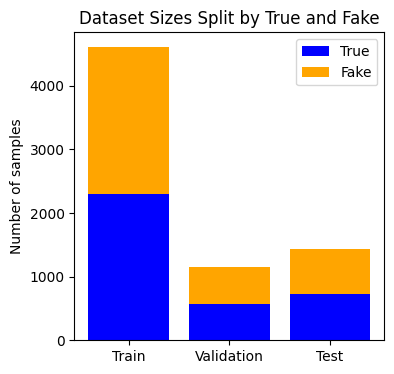

In [ ]:
# Assuming y_train, y_val, y_test are the labels for your datasets
# Replace these with your actual label arrays or series
train_true = sum(np.array(y_train) == 1)
train_fake = sum(np.array(y_train) == 0)
val_true = sum(np.array(y_val) == 1)
val_fake = sum(np.array(y_val) == 0)
test_true = sum(np.array(y_test) == 1)
test_fake = sum(np.array(y_test) == 0)

# Dataset labels
labels = ['Train', 'Validation', 'Test']

# Values for "True" and "Fake" counts in each dataset
true_values = [train_true, val_true, test_true]
fake_values = [train_fake, val_fake, test_fake]

# Plotting the stacked bar chart
plt.figure(figsize=(4, 4))

# Plot the "True" portion of the bars
plt.bar(labels, true_values, color='blue', label='True')

# Plot the "Fake" portion on top of the "True" portion
plt.bar(labels, fake_values, bottom=true_values, color='orange', label='Fake')

# Adding labels and title
plt.ylabel('Number of samples')
plt.title('Dataset Sizes Split by True and Fake')
plt.legend()

# Display the plot
plt.show()

## Training

In [32]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metrics_dict = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=1e-5),
    num_epochs=5,
    device=device)


Epoch 1 [Training]:   0%|          | 0/952 [00:14<?, ?it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Average Loss')

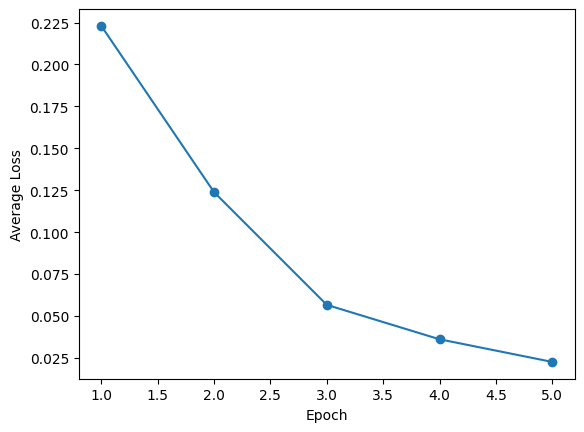

In [ ]:
epochs = np.arange(1, len(metrics_dict['train_loss']) + 1, 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics_dict['train_loss'], marker='o', label='Training Loss')
plt.plot(epochs, metrics_dict['val_loss'], marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Testing the Results

In [ ]:
y_true, y_pred = evaluate_model(model, test_dataloader, device)

In [ ]:
report = classification_report(y_true, y_pred, target_names=["Fake", "Real"])
print(report)   

              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97       716
        Real       0.96      0.99      0.97       724

    accuracy                           0.97      1440
   macro avg       0.98      0.97      0.97      1440
weighted avg       0.98      0.97      0.97      1440



## Saving Model

In [ ]:
model.save_pretrained("BERT_retrained_FakeRecogna")

# Save the metrics dictionary to a JSON file
with open('BERT_retrained_FakeRecogna_metrics.json', 'w') as f:
    json.dump(metrics_dict, f)

# XLNet Model

## Tokenizing

We will use the pretrained XLNetTokenizer from HuggingFace

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
inputs_ids = [
    tokenizer.encode(
        text, 
        add_special_tokens=True, 
        return_tensors="pt", 
        truncation=True, 
        padding='max_length', 
        max_length=512) 
    for text in df.text]

[tensor([[   17,     0,   347,  5896,  2100,    17,  2409,  1880,   221,  7697,
             46,  6109,   407,    17,  8713,    17, 17850,    23,    17, 17272,
           2096,    24,   155,    17,  1895,    17,    93,   221,  1277,  2156,
           2654,   407,    24, 12236,    17, 18714,    23,    17,  1022,    17,
          16838,   221,  1277,  2156,  2654,   407,    17,  7578,   213,    24,
             17,  2013,  2748,    17,  9681,    17,    88,  6657,   780,   155,
           8075,    17, 13853,    19, 11760,    17,  1212,  2483,  1079,    19,
             17,  1022,    17,  1512,  1156,    17,  5023, 10107,    17, 22674,
            721,    19,   321,    78,   986,    17,    93,    22,    98,  4304,
           2748,   155,   221,   101,  3657,   407,    17,    93,   221,  7433,
           6225, 12485,  6536,   407, 11760,    17,  6752,  1841, 17883,    23,
            102,  1937, 10012,    23,    19, 16960,  9059,   712,    17,  1895,
             17,   202, 10564,  9817,   

In [ ]:
inputs_ids

## Creating the Dataloader

In [ ]:
# Original train-test split
y = df.label.tolist()
X_train, X_test, y_train, y_test = train_test_split(
    input_ids, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state=SEED)

# Additional train-validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    stratify=y_train,
    random_state=SEED)

# Create TensorDatasets
train_dataset = TensorDataset(torch.stack(X_train).squeeze(1), torch.tensor(y_train))
val_dataset = TensorDataset(torch.stack(X_val).squeeze(1), torch.tensor(y_val))
test_dataset = TensorDataset(torch.stack(X_test).squeeze(1), torch.tensor(y_test))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

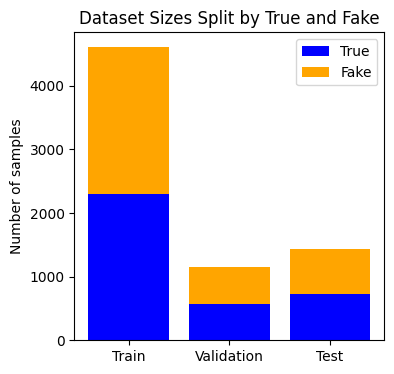

In [ ]:
# Assuming y_train, y_val, y_test are the labels for your datasets
# Replace these with your actual label arrays or series
train_true = sum(np.array(y_train) == 1)
train_fake = sum(np.array(y_train) == 0)
val_true = sum(np.array(y_val) == 1)
val_fake = sum(np.array(y_val) == 0)
test_true = sum(np.array(y_test) == 1)
test_fake = sum(np.array(y_test) == 0)

# Dataset labels
labels = ['Train', 'Validation', 'Test']

# Values for "True" and "Fake" counts in each dataset
true_values = [train_true, val_true, test_true]
fake_values = [train_fake, val_fake, test_fake]

# Plotting the stacked bar chart
plt.figure(figsize=(4, 4))

# Plot the "True" portion of the bars
plt.bar(labels, true_values, color='blue', label='True')

# Plot the "Fake" portion on top of the "True" portion
plt.bar(labels, fake_values, bottom=true_values, color='orange', label='Fake')

# Adding labels and title
plt.ylabel('Number of samples')
plt.title('Dataset Sizes Split by True and Fake')
plt.legend()

# Display the plot
plt.show()

## Training

In [ ]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

In [ ]:
metrics_dict = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=1e-5),
    num_epochs=5,
    device=device)

Epoch 1 [Training]:   0%|          | 1/576 [01:09<11:06:29, 69.55s/it, loss=0.6433]


KeyboardInterrupt: 

Text(0, 0.5, 'Average Loss')

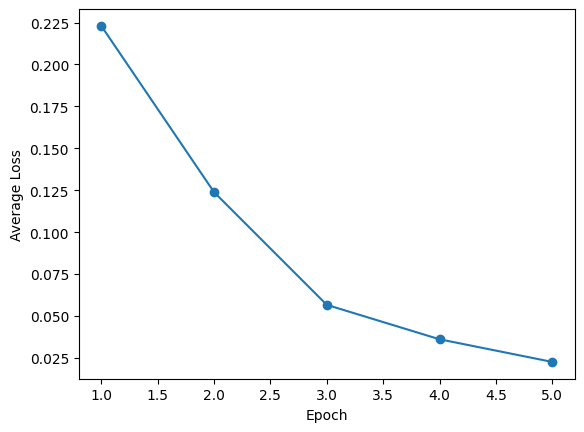

In [ ]:
epochs = np.arange(1, len(metrics_dict['train_loss']) + 1, 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics_dict['train_loss'], marker='o', label='Training Loss')
plt.plot(epochs, metrics_dict['val_loss'], marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Testing the Results

In [ ]:
y_true, y_pred = evaluate_model(model, test_dataloader, device)

In [ ]:
report = classification_report(y_true, y_pred, target_names=["Fake", "Real"])
print(report)   

              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97       716
        Real       0.96      0.99      0.97       724

    accuracy                           0.97      1440
   macro avg       0.98      0.97      0.97      1440
weighted avg       0.98      0.97      0.97      1440



## Saving Model

In [ ]:
model.save_pretrained("XLNet_retrained_FakeRecogna")

# Save the metrics dictionary to a JSON file
with open('XLNet_retrained_FakeRecogna_metrics.json', 'w') as f:
    json.dump(metrics_dict, f)